In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# loading the data
df = pd.read_csv('../../data/LSTMGamesStandardized.csv')

In [9]:
min_season = 2004
# Try with a shorter season
df = df[df['SEASON'] >= min_season]

In [10]:
split_fraction = 0.70
step = 1
past = 5
future = 0
learning_rate = 0.001
batch_size = 256
epochs = 100

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [11]:
season_list = pd.unique(df['SEASON'])

In [6]:
df

,SEASON,GAME_DATE,TEAM_ID,FGM_DIFF,FGA_DIFF,FG3M_DIFF,FTM_DIFF,FTA_DIFF,OREB_DIFF,DREB_DIFF,AST_DIFF,STL_DIFF,TOV_DIFF,PF_DIFF,PTS_DIFF,WIN,HOME_GAME
0,2002,2002-10-30,1610612737,-3.0,-3,2,-7.0,-7.0,-6,-7,-3,5,3,4.0,-11,0,0
1,2002,2002-10-31,1610612737,6.0,-1,-1,-4.0,-3.0,-2,5,3,-3,2,2.0,7,1,1
2,2002,2002-11-02,1610612737,-1.0,-12,1,7.0,5.0,0,4,10,-8,9,-5.0,6,1,1
3,2002,2002-11-05,1610612737,8.0,-7,2,-2.0,-5.0,-3,13,8,3,6,7.0,16,1,0
4,2002,2002-11-06,1610612737,-2.0,-2,0,-1.0,1.0,6,3,-9,2,5,3.0,-5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2018,2019-04-01,1610612766,-2.0,11,-8,3.0,3.0,5,-8,-15,5,-7,-5.0,-9,0,0
38012,2018,2019-04-03,1610612766,-2.0,5,-3,13.0,15.0,4,-4,-6,6,-8,-12.0,6,1,0
38013,2018,2019-04-05,1610612766,1.0,14,4,-4.0,-6.0,3,-6,1,4,-7,0.0,2,1,1
38014,2018,2019-04-07,1610612766,4.0,-4,0,5.0,8.0,-10,-1,3,2,-2,-5.0,13,1,0


In [12]:
team_list = pd.unique(df['TEAM_ID'])
season_list = pd.unique(df['SEASON'])
# Create None type for dataset
combined_dataset_train = None
combined_dataset_val = None

for team_id in team_list: 
    team_df = df[df['TEAM_ID'] == team_id]
    for season in season_list:
        seasonal_team_df = team_df[team_df['SEASON'] == season]
        
        
        feature_ids = [3,4,5,6,7,8,9,10,11,12,13,14,15]
        team_features = seasonal_team_df.iloc[:,feature_ids]
        team_features.index = seasonal_team_df['GAME_DATE']
        team_train_split = int(split_fraction * int(seasonal_team_df.shape[0]))
        
        # For now we are normalizing per team
        norm_team_features = normalize(team_features.values, team_train_split)
        
        norm_team_features = pd.DataFrame(norm_team_features)
        team_features = pd.DataFrame(team_features.values)
        
        train_data = norm_team_features.loc[0 : team_train_split - 1]
        val_data = norm_team_features.loc[team_train_split:]
        
        # Create Training Dataset
        start = past + future
        end = start + team_train_split

        x_train = train_data[[i for i in range(len(feature_ids) - 1)]].values
        y_train = team_features.iloc[start:end][[12]]

        sequence_length = int(past / step)
        
        dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x_train,
        y_train,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

        x_end = len(val_data) - past - future

        # Validation Dataset now
        label_start = team_train_split + past + future

        x_val = val_data.iloc[:x_end][[i for i in range(len(feature_ids) - 1)]].values
        y_val = team_features.iloc[label_start:][[12]]

        
        dataset_val = keras.preprocessing.timeseries_dataset_from_array(
            x_val,
            y_val,
            sequence_length=sequence_length,
            sampling_rate=step,
            batch_size=batch_size,
        )

        if combined_dataset_train is None:
            combined_dataset_train = dataset_train
            combined_dataset_val = dataset_val
        else:
            combined_dataset_train = dataset_train.concatenate(dataset_train)
            combined_dataset_val = combined_dataset_val.concatenate(dataset_val) 
        
        

In [13]:
for batch in combined_dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

for batch in combined_dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


2022-12-12 10:52:10.216640: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Input shape: (47, 5, 12)
Target shape: (47, 1)
Input shape: (14, 5, 12)
Target shape: (14, 1)


In [15]:
# Use Keras LSTM layer to consruct a model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32,dropout=0.1)(inputs)
outputs = keras.layers.Dense(1, activation='sigmoid')(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 12)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                5760      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [16]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", min_delta=0, patience=20)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_binary_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    combined_dataset_train,
    epochs=epochs,
    validation_data=combined_dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2022-12-12 10:53:12.841938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-12 10:53:13.020220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 1s - loss: 0.6930 - binary_accuracy: 0.4894

2022-12-12 10:53:13.332810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-12 10:53:46.445305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-12 10:53:46.534709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_binary_accuracy improved from -inf to 0.50544, saving model to model_checkpoint.h5
2/2 [==============================] - 42s 40s/step - loss: 0.6890 - binary_accuracy: 0.5532 - val_loss: 0.6940 - val_binary_accuracy: 0.5054
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6827 - binary_accuracy: 0.5957
Epoch 2: val_binary_accuracy improved from 0.50544 to 0.50736, saving model to model_checkpoint.h5
2/2 [==============================] - 7s 7s/step - loss: 0.6815 - binary_accuracy: 0.6064 - val_loss: 0.6942 - val_binary_accuracy: 0.5074
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6779 - binary_accuracy: 0.6170
Epoch 3: val_binary_accuracy did not improve from 0.50736
2/2 [==============================] - 7s 7s/step - loss: 0.6767 - binary_accuracy: 0.6170 - val_loss: 0.6945 - val_binary_accuracy: 0.5027
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6731 - binary_accuracy: 0.6383
Epoch 4: val_binary_accu

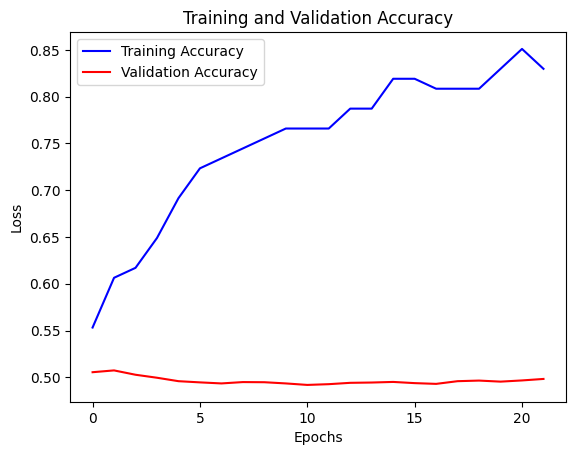

In [17]:

def visualize_loss(history, title):
    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]
    epochs = range(len(accuracy))
    plt.figure()
    plt.plot(epochs, accuracy, "b", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Accuracy")

In [18]:
for x,y in dataset_val.take(1):
    print(model.predict(x)[2])
    print(y[2])

1/1 [==============================] - 0s 262ms/step
[0.41400078]
tf.Tensor([0.], shape=(1,), dtype=float64)


2022-12-12 10:56:12.693148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-12 10:56:12.747465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
